In [1]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input

In [2]:
# Load and preprocess the data
def load_and_preprocess_data(data):
    images = []
    labels = []
    for label, image_paths in data.items():
        for path in image_paths:
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
            img = cv2.resize(img, (224, 224))  # Resize image to VGG16 input size
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [3]:
# Load data
path = pathlib.Path(r"C:\Users\akshi\OneDrive\Desktop\gmu\ait 736\mid project\kvasir-dataset\kvasir-dataset")

In [4]:
dyed_ifted_polyps = list(path.glob('dyed-lifted-polyps/*'))
dyed_resection_margins = list(path.glob('dyed-resection-margins/*'))
esophagitis = list(path.glob('esophagitis/*'))
normal_cecum = list(path.glob('normal-cecum/*'))
normal_pylorus = list(path.glob('normal-pylorus/*'))
normal_z_line = list(path.glob('normal-z-line/*'))
polyps = list(path.glob('polyps/*'))
ulcerative_colitis = list(path.glob('ulcerative-colitis/*'))

In [5]:
data = {
    'dyed-lifted-polyps' : dyed_ifted_polyps ,
    'dyed-resection-margins' : dyed_resection_margins,
    'esophagitis' : esophagitis,
    'normal-cecum' : normal_cecum,
    'normal-pylorus' : normal_pylorus,
    'normal-z-line' : normal_z_line,
    'polyps' : polyps,
    'ulcerative-colitis' : ulcerative_colitis
}

polys_labels = {
    0:'dyed-lifted-polyps',
    1:'dyed-resection-margins',
    2:'esophagitis',
    3:'normal-cecum',
    4:'normal-pylorus',
    5:'normal-z-line',
    6:'polyps',
    7:'ulcerative-colitis'
}

In [6]:
images, labels = load_and_preprocess_data(data)

In [7]:
# Split the data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [8]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [9]:
# Load DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build your classification model on top of the pre-trained DenseNet model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Adjust the output units based on the number of classes
])

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Preprocess the data using DenseNet's preprocess_input function
train_data_densenet = densenet_preprocess_input(train_data)
val_data_densenet = densenet_preprocess_input(val_data)
test_data_densenet = densenet_preprocess_input(test_data)

In [11]:
# Train the model
history = model.fit(train_data_densenet, train_labels_encoded, epochs=10, batch_size=32, validation_data=(val_data_densenet, val_labels_encoded))

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4734 - loss: 1.5111 - val_accuracy: 0.8219 - val_loss: 0.4516
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7847 - loss: 0.5632 - val_accuracy: 0.8578 - val_loss: 0.3703
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8158 - loss: 0.4561 - val_accuracy: 0.8516 - val_loss: 0.3707
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8497 - loss: 0.3792 - val_accuracy: 0.8391 - val_loss: 0.3539
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8496 - loss: 0.3611 - val_accuracy: 0.8594 - val_loss: 0.3270
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8643 - loss: 0.3517 - val_accuracy: 0.8594 - val_loss: 0.3329
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8826 - loss: 0.2921 - val_accuracy: 0.8594 - val_loss: 0.3582
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9024 - loss: 0.2586 - val_accuracy: 0.8781 - v

In [12]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data_densenet, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9045 - loss: 0.2496
Test Accuracy: 0.9012500047683716


In [13]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (32, 7, 7, 1024)       │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (32, 1024)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 256)              │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 8)                │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,830,874 (29.87 MB)

 Trainable params: 264,456 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 528,914 (2.02 MB)

In [15]:
precision = precision_score(test_labels_encoded, y_pred_classes, average='macro')
recall = recall_score(test_labels_encoded, y_pred_classes, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.9030350354188442
Recall: 0.9058453335771437


25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
ROC AUC Score: 0.9930187375286718


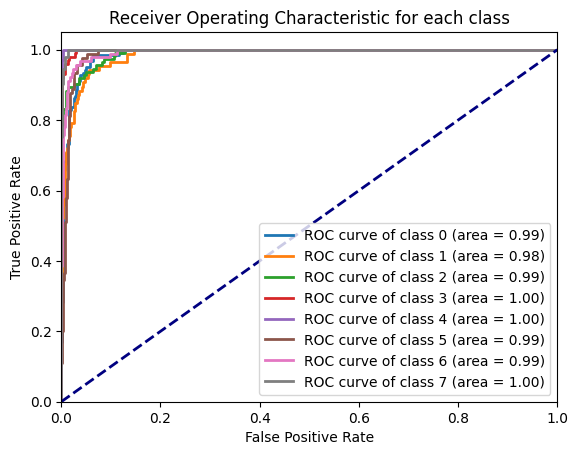

In [17]:
# ROC, AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for each class
y_pred_proba = model.predict(test_data_densenet)

# Binarize the true labels
y_test_binarized = label_binarize(test_labels_encoded, classes=np.unique(test_labels_encoded))

# Calculate AUC for each class
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print(f'ROC AUC Score: {roc_auc}')

# Plot ROC curve for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


In [18]:
# Define model creation function
def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')  # Adjust the output units based on the number of classes
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
# Define the number of classes
num_classes = 8  # Update with the number of classes in your dataset

# Perform cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(train_data_densenet, train_labels_encoded)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    # Create ResNet50 model
    model = create_model()
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train the model
    history = model.fit(train_data_densenet[train_index], train_labels_encoded[train_index], epochs=10, batch_size=32, validation_data=(train_data_densenet[val_index], train_labels_encoded[val_index]), verbose=1)
    
    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(train_data_densenet[val_index], train_labels_encoded[val_index], verbose=0)
    print(f"Validation Accuracy: {val_acc}")
    cv_scores.append(val_acc)

# Calculate and print the mean cross-validation score
mean_cv_score = np.mean(cv_scores)
print(f"Mean Cross-Validation Accuracy: {mean_cv_score}")

Fold 1/5
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4388 - loss: 1.6425 - val_accuracy: 0.7891 - val_loss: 0.5250
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7692 - loss: 0.5960 - val_accuracy: 0.8203 - val_loss: 0.4247
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8291 - loss: 0.4558 - val_accuracy: 0.8125 - val_loss: 0.4290
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8233 - loss: 0.4333 - val_accuracy: 0.8105 - val_loss: 0.4259
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8588 - loss: 0.3679 - val_accuracy: 0.8281 - val_loss: 0.3772
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8648 - loss: 0.3537 - val_accuracy: 0.8320 - val_loss: 0.3590
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8615 - loss: 0.3520 - val_accuracy: 0.8379 - val_loss: 0.3498
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8849 - loss: 0.2947 - val_accuracy: 0.8418 

25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step


<Figure size 800x800 with 0 Axes>

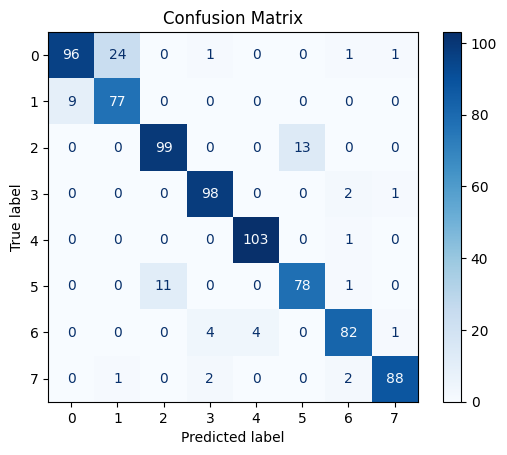

In [20]:
# Generate confusion matrix
predictions = model.predict(test_data_densenet)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels_encoded, predicted_labels)
classes = [str(i) for i in range(8)]  # Assuming you have 8 classes

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()